In [2]:
import psycopg2
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import json
import random
execfile('utils.py')

In [226]:
database = 'fomc'
conn = psycopg2.connect("dbname=" + database + " user=abarciauskas")
cur = conn.cursor()
year = 2007

cur.execute("SELECT termvector FROM corpii WHERE Year = '" + str(year) + "'")
term_vector = cur.fetchall()[0][0]
len(term_vector)

1540

In [49]:
cur.execute("SELECT tfidfvector FROM processed_documents WHERE Year = '" + str(year) + "'"
            " ORDER BY random() LIMIT 1000")
results = cur.fetchall()
len(results)

1000

In [55]:
fomc_docs = [results[i][0] for i in range(len(results))]
print len(fomc_docs)
print len(fomc_docs[0])

1000
1540


In [102]:
from sklearn.metrics.pairwise import cosine_distances

def new_euclidean_distances(X, Y=None, Y_norm_squared=None, squared=False):
    return cosine_distances(X,Y)

# monkey patch (ensure cosine dist function is used)
from sklearn.cluster import KMeans

KMeans.euclidean_distances = new_euclidean_distances 

In [104]:
k = 10
kmeans_model = KMeans(n_clusters=k)
y_pred = kmeans_model.fit_predict(fomc_docs)

In [105]:
from collections import Counter

cluster_dists = Counter(y_pred)
print cluster_dists

Counter({1: 627, 3: 201, 4: 100, 6: 41, 8: 22, 2: 3, 5: 3, 0: 1, 7: 1, 9: 1})


In [106]:
kmeans_model.inertia_

38884.917227755686

In [107]:
ks = range(10,1000,50)
inertias = []
for k in ks:
    kmeans_model = KMeans(n_clusters=k)
    y_pred = kmeans_model.fit_predict(fomc_docs)
    inertias.append(kmeans_model.inertia_)

In [108]:
print inertias

[38581.212831071643, 32989.718096314995, 28960.761442872419, 25319.632713165149, 22143.776711762308, 19364.247191793092, 16835.676661843812, 14516.742774308281, 12502.435276567596, 10573.45906679986, 8852.4921566828998, 7251.9860068740791, 5828.9542141087277, 4553.4817513692651, 3435.1686954418565, 2372.3945319317381, 1488.0999088916712, 775.32442494968325, 296.56886796358589, 18.775605278035997]


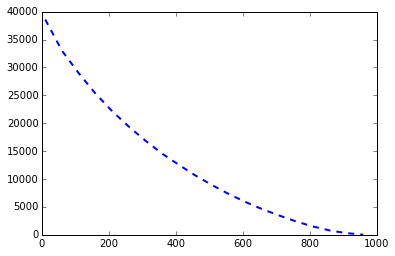

In [109]:
%matplotlib inline
line, = plt.plot(ks, inertias, '--', linewidth=2)

plt.show()

In [111]:
from utils import *

In [275]:
cosine_thresh = 0.33
cur.execute("SELECT Doc1Id,Doc2Id,CosineSimilarity FROM alignments WHERE Year = '" + str(year) + "'"
           " AND CosineSimilarity >= " + str(cosine_thresh) + " ORDER BY random() LIMIT 1000")
cosine_sims = cur.fetchall()
len(cosine_sims)

1000

In [276]:
edges, vertices = create_graph(cosine_sims)
print 'Number vertices in complete graph: ' + str(len(vertices))
print 'Number edges in complete graph: ' + str(len(edges))

Number vertices in complete graph: 816
Number edges in complete graph: 1000


In [277]:
# need to find disconnected graphs
graphs = build_distinct_graphs(vertices)

graph_lengths = [len(graph) for graph in graphs]
fc_graph = graphs[graph_lengths.index(max(graph_lengths))]
print 'Number vertices fully connected graph: ' + str(len(fc_graph))

Number vertices fully connected graph: 413


In [278]:
str_ids = str(fc_graph)
str_ids = str_ids.replace('[', '(')
str_ids = str_ids.replace(']', ')')


cur.execute("SELECT tfidfvector FROM processed_documents WHERE Id IN " + str_ids)
results = cur.fetchall()
len(results)

413

In [279]:
fomc_docs = [results[i][0] for i in range(len(results))]
print len(fomc_docs)
print len(fomc_docs[0])

413
1540


In [313]:
ks = range(5,100,5)
kluster_iters = 30
min_inertias = []
best_models = []
# heurstic to find elbow as described in http://nlp.stanford.edu/IR-book/pdf/16flat.pdf
for k in ks:
    min_inertia = float("inf")
    best_model = None
    for itera in range(kluster_iters):
        kmeans_model = KMeans(n_clusters=k)
        y_pred = kmeans_model.fit_predict(fomc_docs)
        if kmeans_model.inertia_ < min_inertia:
            min_inertia = kmeans_model.inertia_
            best_model = kmeans_model
    best_models.append(best_model)
    min_inertias.append(min_inertia)

print len(ks)
print len(min_inertias)

19
19


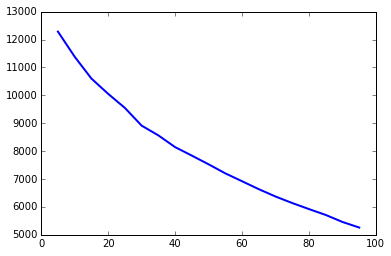

In [314]:
%matplotlib inline
line, = plt.plot(ks, min_inertias, linewidth=2)

plt.show()

In [343]:
chosen_model = best_models[9]
ks[8]

45

In [344]:
y_pred = chosen_model.fit_predict(fomc_docs)
cluster_dists = Counter(y_pred)
print cluster_dists

Counter({4: 138, 14: 29, 15: 16, 17: 16, 24: 16, 8: 14, 9: 14, 11: 13, 5: 11, 23: 11, 26: 10, 36: 10, 13: 9, 30: 9, 43: 8, 1: 7, 45: 7, 2: 5, 19: 5, 27: 5, 29: 5, 44: 5, 22: 4, 39: 4, 3: 3, 6: 3, 10: 3, 12: 3, 48: 3, 16: 2, 31: 2, 32: 2, 37: 2, 40: 2, 46: 2, 0: 1, 7: 1, 18: 1, 20: 1, 21: 1, 25: 1, 28: 1, 33: 1, 34: 1, 35: 1, 38: 1, 41: 1, 42: 1, 47: 1, 49: 1})


In [340]:
word_idcs_for_cluster = np.argwhere(chosen_model.cluster_centers_[19] > 0.25)
len(word_idcs_for_cluster)

6

In [341]:
for idx, word in enumerate(term_vector):
    if idx in word_idcs_for_cluster: print word

forward-look
double-digit
creep
disadvantag
long-horizon
toward


In [360]:
k = 45
min_inertia = float("inf")
kluster_iters = range(10,2000,50)
best_model = None
inertias = []
for itera in kluster_iters:
    kmeans_model = KMeans(n_clusters=k, max_iter=itera)
    y_pred = kmeans_model.fit_predict(fomc_docs)
    inertias.append(kmeans_model.inertia_)
    if kmeans_model.inertia_ < min_inertia:
        min_inertia = kmeans_model.inertia_
        best_model = kmeans_model

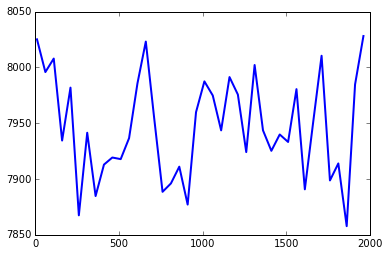

In [361]:
%matplotlib inline
line, = plt.plot(kluster_iters, inertias, linewidth=2)
plt.show()

In [346]:
y_pred = best_model.fit_predict(fomc_docs)
cluster_dists = Counter(y_pred)
print cluster_dists

Counter({1: 196, 20: 17, 10: 15, 23: 15, 32: 13, 33: 13, 9: 11, 22: 11, 6: 10, 30: 9, 3: 8, 7: 8, 27: 8, 35: 7, 2: 5, 15: 5, 42: 5, 14: 4, 37: 4, 4: 3, 8: 3, 12: 3, 17: 3, 29: 3, 36: 3, 43: 3, 0: 2, 11: 2, 13: 2, 18: 2, 21: 2, 24: 2, 25: 2, 34: 2, 38: 2, 5: 1, 16: 1, 19: 1, 26: 1, 28: 1, 31: 1, 39: 1, 40: 1, 41: 1, 44: 1})


In [353]:
word_idcs_for_cluster = np.argwhere(best_model.cluster_centers_[10] > 0.5)
print len(word_idcs_for_cluster)
for idx, word in enumerate(term_vector):
    if idx in word_idcs_for_cluster: print word

9
thu
correct
resurg
confront
litr
good
subpar
mute
incom
